<div align='left' style="width:400px;height:120px;overflow:hidden;">
<a href='http://www.uff.br'>
<img align='left' style='display: block;height: 92%' src='https://github.com/lmarti/jupyter_custom/raw/master/imgs/uff.png' alt='UFF logo' title='UFF logo'/>
</a>
<a href='http://www.ic.uff.br'>
<img align='left' style='display: block;height: 100%' src='https://github.com/lmarti/jupyter_custom/raw/master/imgs/logo-ic.png' alt='IC logo' title='IC logo'/>
</a>
</div>

# Understanding evolutionary strategies and covariance matrix adaptation

## Luis Martí, [IC](http://www.ic.uff.br)/[UFF](http://www.uff.br)

[http://lmarti.com](http://lmarti.com); [lmarti@ic.uff.br](mailto:lmarti@ic.uff.br) 

[Advanced Evolutionary Computation: Theory and Practice](http://lmarti.com/aec-2014) 

The notebook is better viewed rendered as slides. You can convert it to slides and view them by:
- using [nbconvert](http://ipython.org/ipython-doc/1/interactive/nbconvert.html) with a command like:
  ```bash
  $ ipython nbconvert --to slides --post serve <this-notebook-name.ipynb>
  ```
- installing [Reveal.js - Jupyter/IPython Slideshow Extension](https://github.com/damianavila/live_reveal)
- using the online [IPython notebook slide viewer](https://slideviewer.herokuapp.com/) (some slides of the notebook might not be properly rendered).

This and other related IPython notebooks can be found at the course github repository:
* [https://github.com/lmarti/evolutionary-computation-course](https://github.com/lmarti/evolutionary-computation-course)

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm 
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import norm, multivariate_normal
import math

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] ='\\usepackage{libertine}\n\\usepackage[utf8]{inputenc}'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

### Statistics recap

* [Random variable](http://en.wikipedia.org/wiki/Random_variable): a variable whose value is subject to variations due to __chance__. A random variable can take on a set of possible different values, each with an associated probability, in contrast to other mathematical variables.

* [Probability distribution](http://en.wikipedia.org/wiki/Probability_distribution): mathematical function describing the possible values of a random variable and their associated probabilities.

* [Probability density function (pdf)](http://en.wikipedia.org/wiki/Probability_density_function) of a __continuous random variable__ is a function that describes the relative likelihood for this random variable to take on a given value. 
     * The probability of the random variable falling within a particular range of values is given by the integral of this variable’s density over that range.
     * The probability density function is nonnegative everywhere, and its integral over the entire space is equal to one.
     
<img src='http://upload.wikimedia.org/wikipedia/commons/2/25/The_Normal_Distribution.svg' width='50%' align='center'/>
 

### [Moments](http://en.wikipedia.org/wiki/Moment_(mathematics)

The probability distribution of a random variable is often characterised by a small number of parameters, which also have a practical interpretation.

* [Mean](http://en.wikipedia.org/wiki/Mean) (a.k.a expected value) refers to one measure of the central tendency either of a probability distribution or of the random variable characterized by that distribution.
    * population mean: $\mu = \operatorname{E}[X]$.
    * estimation of sample mean: $\bar{x}$.
* [Standard deviation](http://en.wikipedia.org/wiki/Standard_deviation) measures the amount of variation or dispersion from the mean.
    * population deviation:
    $$
\sigma = \sqrt{\operatorname E[X^2]-(\operatorname E[X])^2} = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - \mu)^2}.
$$
    * unbiased estimator:
    $$ 
    s^2 = \frac{1}{N-1} \sum_{i=1}^N (x_i - \overline{x})^2.
    $$

### Two samples

In [62]:
sample1 = np.random.normal(0, 0.5, 1000)
sample2 = np.random.normal(1,1,500)

In [63]:
def plot_normal_sample(sample, mu, sigma):
    'Plots an histogram and the normal distribution corresponding to the parameters.'
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    plt.plot(x, norm.pdf(x, mu, sigma), 'b', lw=2)
    plt.hist(sample, 30, normed=True, alpha=0.2)
    plt.annotate('3$\sigma$', 
                     xy=(mu + 3*sigma, 0),  xycoords='data',
                     xytext=(0, 100), textcoords='offset points',
                     fontsize=15,
                     arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc,angleA=180,armA=20,angleB=90,armB=15,rad=7"))
    plt.annotate('-3$\sigma$', 
                     xy=(mu -3*sigma, 0), xycoords='data', 
                     xytext=(0, 100), textcoords='offset points',
                     fontsize=15,
                     arrowprops=dict(arrowstyle="->",
                                     connectionstyle="arc,angleA=180,armA=20,angleB=90,armB=15,rad=7"))

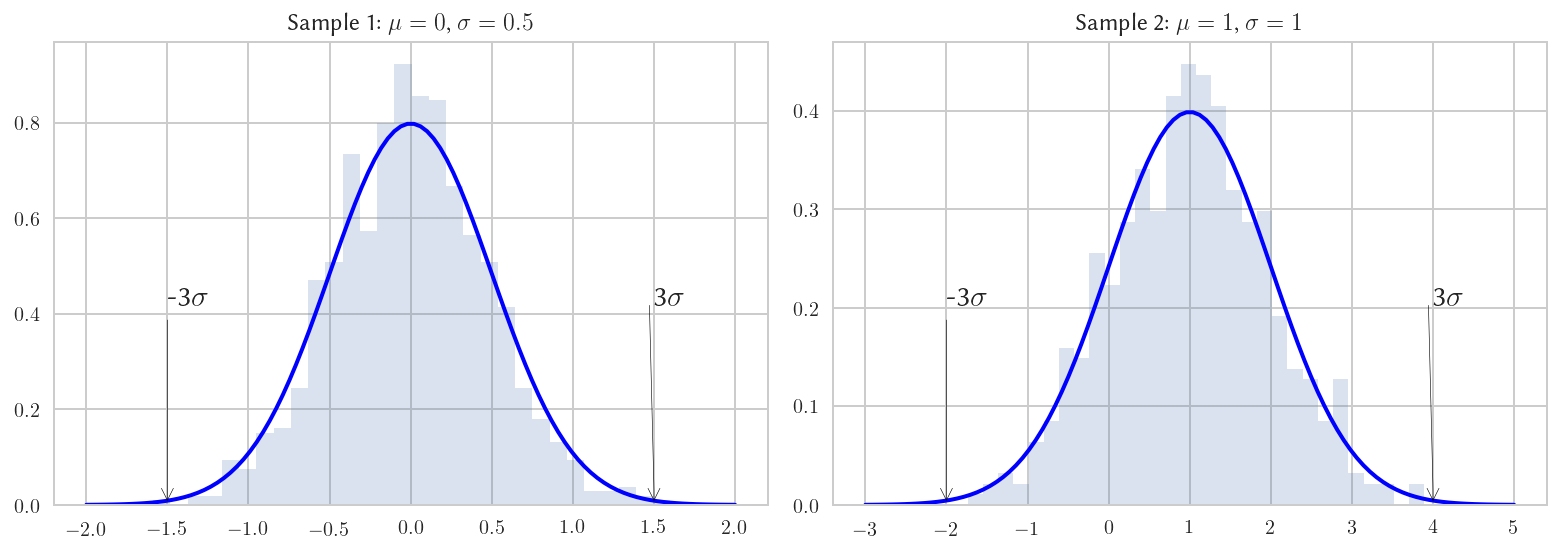

In [64]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_normal_sample(sample1, 0, 0.5)
plt.title('Sample 1: $\mu=0$, $\sigma=0.5$')
plt.subplot(122)
plot_normal_sample(sample2, 1, 1)
plt.title('Sample 2: $\mu=1$, $\sigma=1$')
plt.tight_layout();

In [65]:
print('Sample 1; estimated mean:', sample1.mean(), ' and std. dev.: ', sample1.std())
print('Sample 2; estimated mean:', sample2.mean(), ' and std. dev.: ', sample2.std())

Sample 1; estimated mean: -0.000176330861078  and std. dev.:  0.472785600332
Sample 2; estimated mean: 1.00435499156  and std. dev.:  0.969981727482


[Covariance](http://en.wikipedia.org/wiki/Covariance) is a measure of how much two random variables change together. 
$$
\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]},
$$
$$
\operatorname{cov}(X,X) = s(X),
$$

* The sign of the covariance therefore shows the tendency in the linear relationship between the variables. 
* The magnitude of the covariance is not easy to interpret. 
* The normalized version of the covariance, the correlation coefficient, however, shows by its magnitude the strength of the linear relation.

### Understanding covariance

In [66]:
sample_2d = np.array(list(zip(sample1, np.ones(len(sample1))))).T

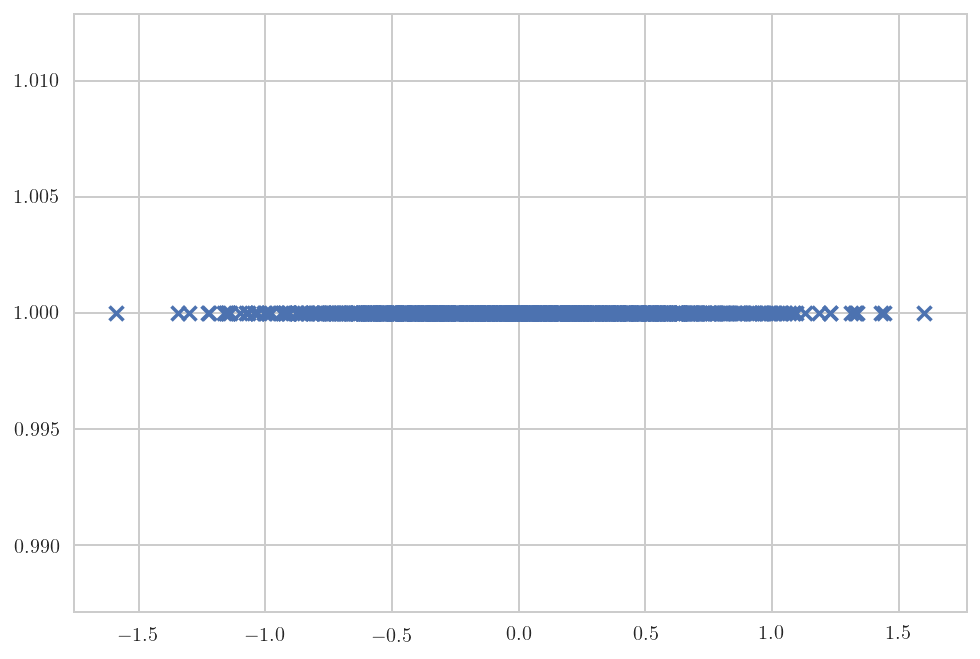

In [67]:
plt.scatter(sample_2d[0,:], sample_2d[1,:], marker='x');

In [68]:
np.cov(sample_2d) # computes covariance between the two components of the sample

array([[ 0.22374997,  0.        ],
       [ 0.        ,  0.        ]])

As the sample is only distributed along one axis, the covariance does not detects any relationship between them.

What happens when we rotate the sample?

In [69]:
def rotate_sample(sample, angle=-45):
    'Rotates a sample by `angle` degrees.'
    theta = (angle/180.) * np.pi
    rot_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                           [np.sin(theta), np.cos(theta)]])
    return sample.T.dot(rot_matrix).T

In [70]:
rot_sample_2d = rotate_sample(sample_2d)

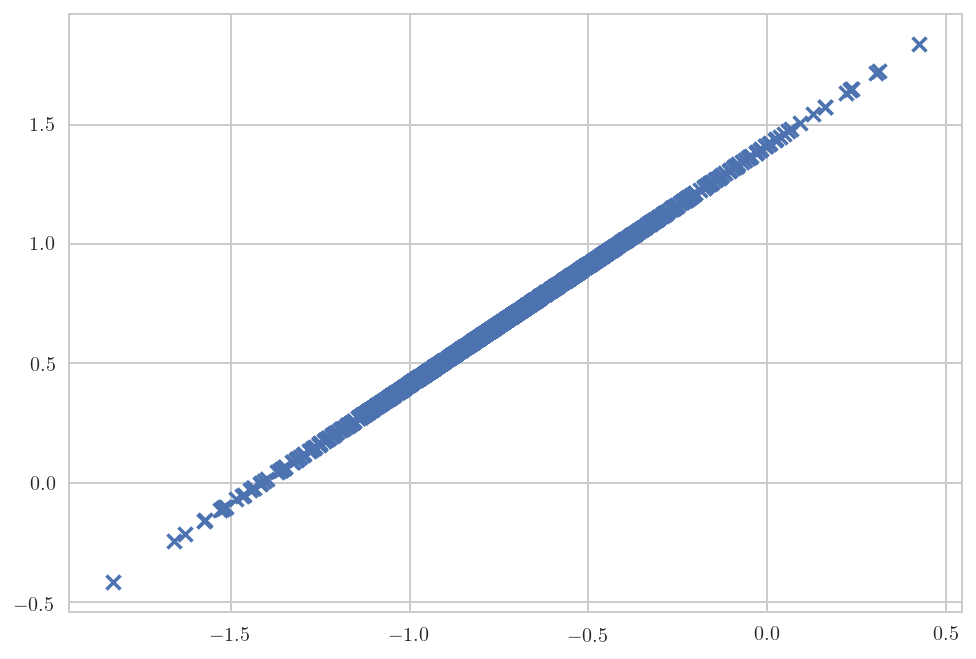

In [71]:
plt.scatter(rot_sample_2d[0,:], rot_sample_2d[1,:], marker='x');

In [72]:
np.cov(rot_sample_2d)

array([[ 0.11187499,  0.11187499],
       [ 0.11187499,  0.11187499]])

### A two-dimensional normally-distributed variable

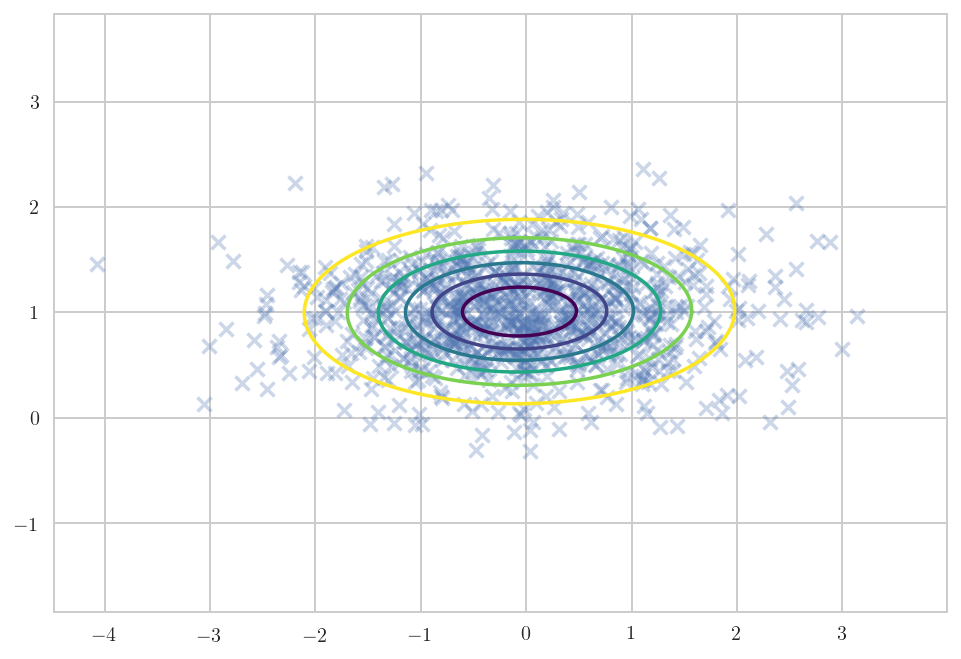

In [74]:
mu = [0,1]
cov = [[1,0],[0,0.2]] # diagonal covariance, points lie on x or y-axis
sample = np.random.multivariate_normal(mu,cov,1000).T
plt.scatter(sample[0], sample[1], marker='x', alpha=0.29)

estimated_mean = sample.mean(axis=1)
estimated_cov = np.cov(sample)
e_x,e_y = np.random.multivariate_normal(estimated_mean,estimated_cov,500).T

plt.plot(e_x,e_y,'rx', alpha=0.47)
x, y = np.mgrid[-4:4:.01, -1:3:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(estimated_mean, estimated_cov)
plt.contour(x, y, rv.pdf(pos), cmap=cm.viridis_r, lw=4)
plt.axis('equal');

### This is better understood in 3D

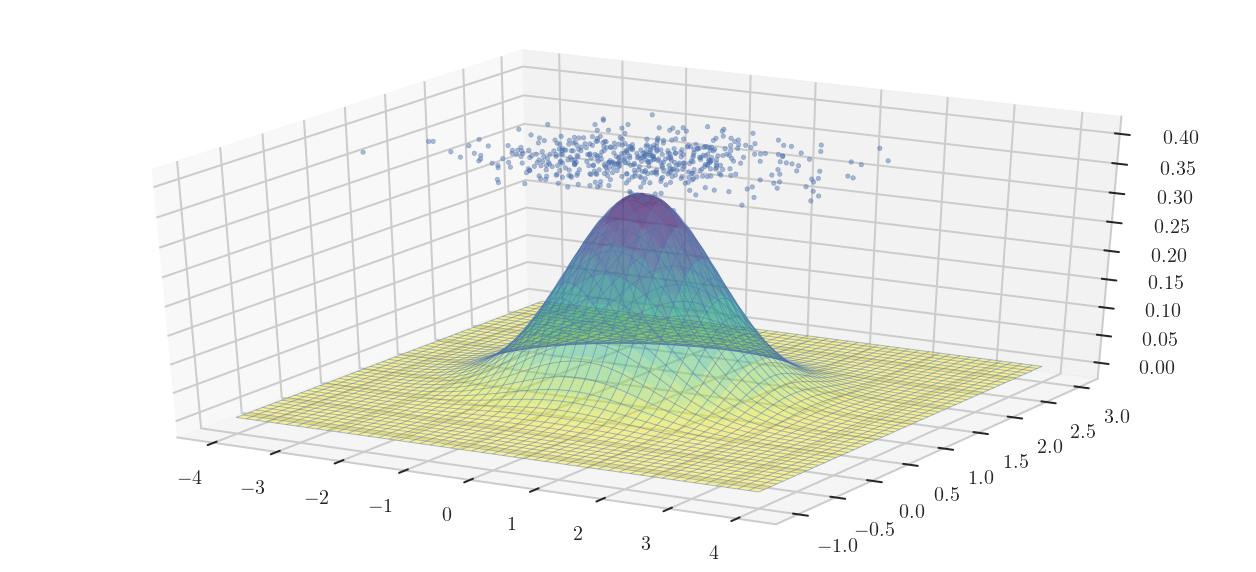

In [76]:
fig = plt.figure(figsize=(11,5))
ax = fig.gca(projection='3d')
ax.plot_surface(x, y, rv.pdf(pos), cmap=cm.viridis_r, rstride=30, cstride=10, linewidth=1, alpha=0.47)
ax.plot_wireframe(x, y, rv.pdf(pos), linewidth=0.47, alpha=0.47)
ax.scatter(e_x, e_y, 0.4, marker='.', alpha=0.47)
ax.axis('tight');

Again, what happens if we rotate the sample?

In [77]:
rot_sample = rotate_sample(sample)
estimated_mean = rot_sample.mean(axis=1)
estimated_cov = np.cov(rot_sample)
e_x,e_y = np.random.multivariate_normal(estimated_mean,estimated_cov,500).T

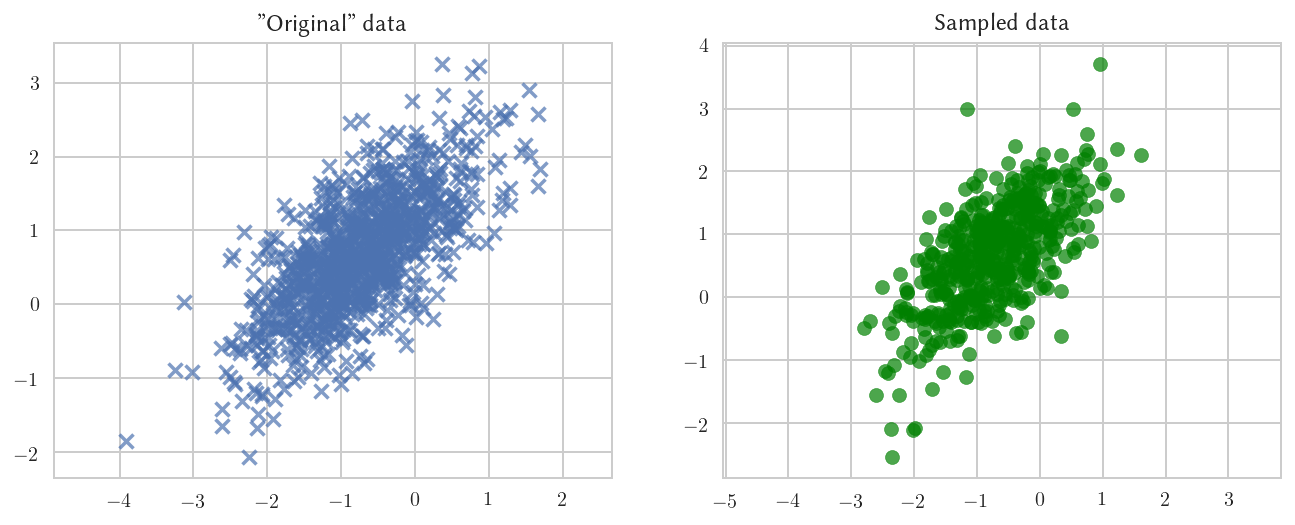

In [78]:
fig = plt.figure(figsize=(11,4))
plt.subplot(121)
plt.scatter(rot_sample[0,:], rot_sample[1,:], marker='x', alpha=0.7)
plt.title('"Original" data')
plt.axis('equal')
plt.subplot(122)
plt.scatter(e_x, e_y, marker='o', color='g', alpha=0.7)
plt.title('Sampled data')
plt.axis('equal');

Covariance captures the dependency and can model disposition of the "original" sample.

In [79]:
x, y = np.mgrid[-4:4:.01, -3:3:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(estimated_mean, estimated_cov)

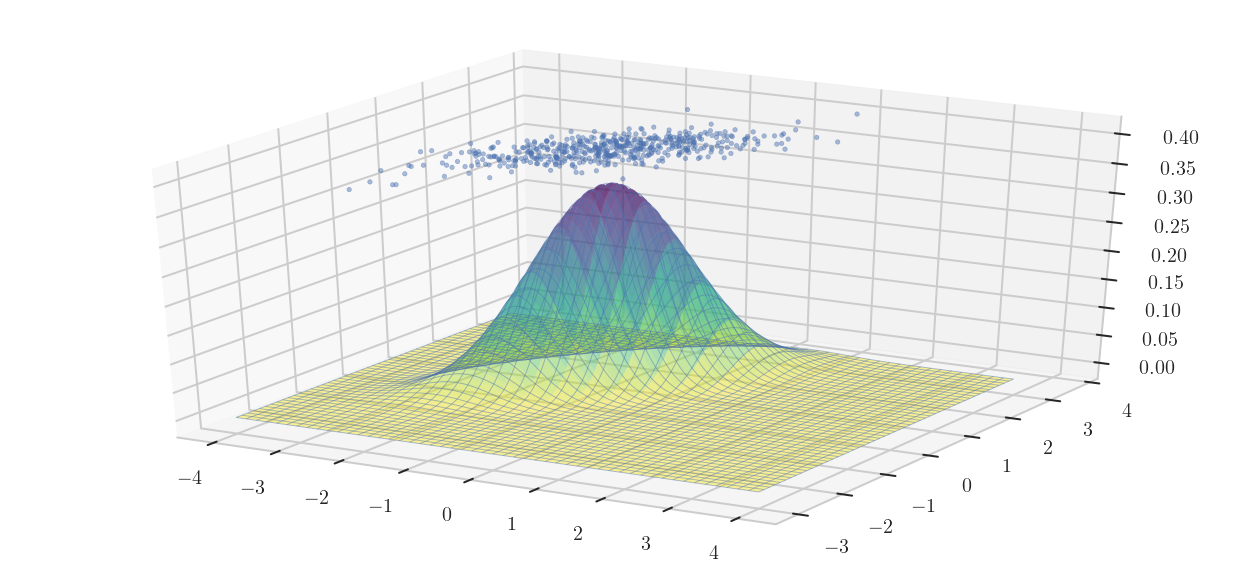

In [80]:
fig = plt.figure(figsize=(11,5))
ax = fig.gca(projection='3d')
ax.plot_surface(x, y, rv.pdf(pos), cmap=cm.viridis_r, rstride=30, cstride=10, linewidth=1, alpha=0.47)
ax.plot_wireframe(x, y, rv.pdf(pos), linewidth=0.47, alpha=0.47)
ax.scatter(e_x, e_y, 0.4, marker='.', alpha=0.47)
ax.axis('tight');

# Evolutionary Strategies

We will be using DEAP again to present some of the ES main concepts.

In [19]:
import array, random, time, copy

from deap import base, creator, benchmarks, tools, algorithms

random.seed(42) # Fixing a random seed: You should not do this in practice.

Before we dive into the discussion lets code some support functions.

In [20]:
def plot_problem_3d(problem, bounds, resolution=100., 
                    cmap=cm.viridis_r, rstride=10, cstride=10, 
                    linewidth=0.15, alpha=0.65, ax=None):
    'Plots a given deap benchmark problem in 3D mesh.'
    (minx,miny),(maxx,maxy) = bounds
    x_range = np.arange(minx, maxx, (maxx-minx)/resolution)
    y_range = np.arange(miny, maxy, (maxy-miny)/resolution)
    
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros((len(x_range), len(y_range)))
    
    for i in range(len(x_range)):
        for j in range(len(y_range)):
            Z[i,j] = problem((x_range[i], y_range[j]))[0]
    
    if not ax:
        fig = plt.figure(figsize=(11,6))
        ax = fig.gca(projection='3d')
        
    cset = ax.plot_surface(X, Y, Z, cmap=cmap, rstride=rstride, cstride=cstride, linewidth=linewidth, alpha=alpha)

In [21]:
def plot_problem_controur(problem, bounds, optimum=None,
                          resolution=100., cmap=cm.viridis_r, 
                          rstride=1, cstride=10, linewidth=0.15,
                          alpha=0.65, ax=None):
    'Plots a given deap benchmark problem as a countour plot'
    (minx,miny),(maxx,maxy) = bounds
    x_range = np.arange(minx, maxx, (maxx-minx)/resolution)
    y_range = np.arange(miny, maxy, (maxy-miny)/resolution)
    
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros((len(x_range), len(y_range)))
    
    for i in range(len(x_range)):
        for j in range(len(y_range)):
            Z[i,j] = problem((x_range[i], y_range[j]))[0]
    
    if not ax:
        fig = plt.figure(figsize=(6,6))
        ax = fig.gca()
        ax.set_aspect('equal')
        ax.autoscale(tight=True)
    
    cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride, cstride=cstride, linewidth=linewidth, alpha=alpha)
    
    if optimum:
        ax.plot(optimum[0], optimum[1], 'bx', linewidth=4, markersize=15)

In [22]:
def plot_cov_ellipse(pos, cov, volume=.99, ax=None, fc='lightblue', ec='darkblue', alpha=1, lw=1):
    ''' Plots an ellipse that corresponds to a bivariate normal distribution.
    Adapted from http://www.nhsilbert.net/source/2014/06/bivariate-normal-ellipse-plotting-in-python/'''
    from scipy.stats import chi2
    from matplotlib.patches import Ellipse

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    kwrg = {'facecolor':fc, 'edgecolor':ec, 'alpha':alpha, 'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * np.sqrt(chi2.ppf(volume,2)) * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwrg)
    ax.add_artist(ellip)

### Why benchmarks (test) functions?

In applied mathematics, [test functions](http://en.wikipedia.org/wiki/Test_functions_for_optimization), also known as artificial landscapes, are useful to evaluate characteristics of optimization algorithms, such as:

* Velocity of convergence.
* Precision.
* Robustness.
* General performance.

DEAP has a number of test problems already implemented. See http://deap.readthedocs.org/en/latest/api/benchmarks.html

### [Bohachevsky benchmark problem](http://deap.readthedocs.org/en/latest/api/benchmarks.html#deap.benchmarks.bohachevsky)

$$\text{minimize } f(\mathbf{x}) = \sum_{i=1}^{N-1}(x_i^2 + 2x_{i+1}^2 - 0.3\cos(3\pi x_i) - 0.4\cos(4\pi x_{i+1}) + 0.7), \mathbf{x}\in \left[-100,100\right]^n,$$

> Optimum in $\mathbf{x}=\mathbf{0}$, $f(\mathbf{x})=0$.

In [23]:
current_problem = benchmarks.bohachevsky

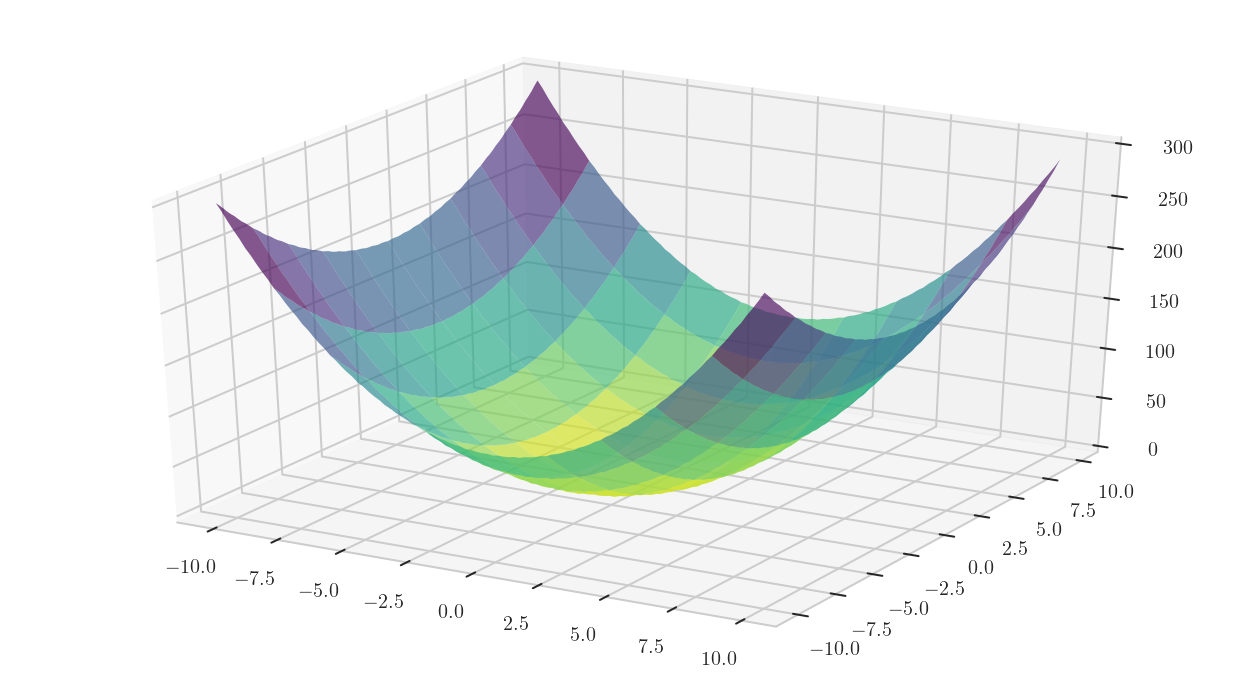

In [24]:
plot_problem_3d(current_problem, ((-10,-10), (10,10)))

The Bohachevsky problem has many local optima.

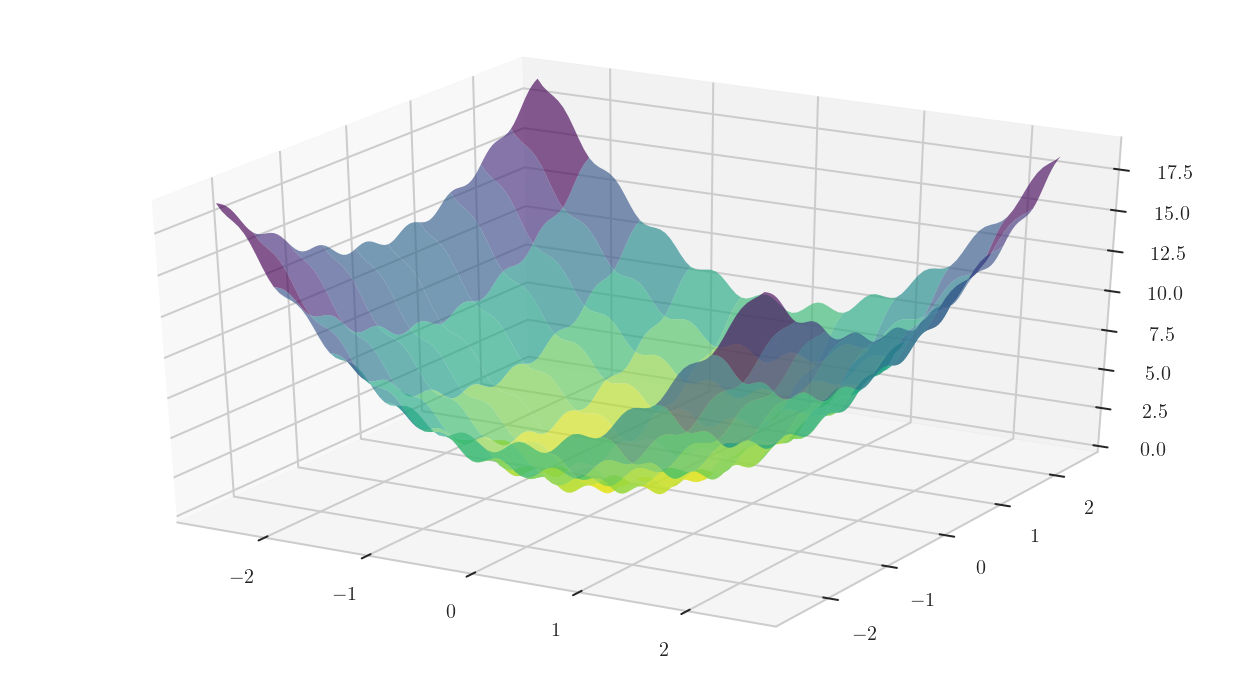

In [25]:
plot_problem_3d(current_problem, ((-2.5,-2.5), (2.5,2.5)))

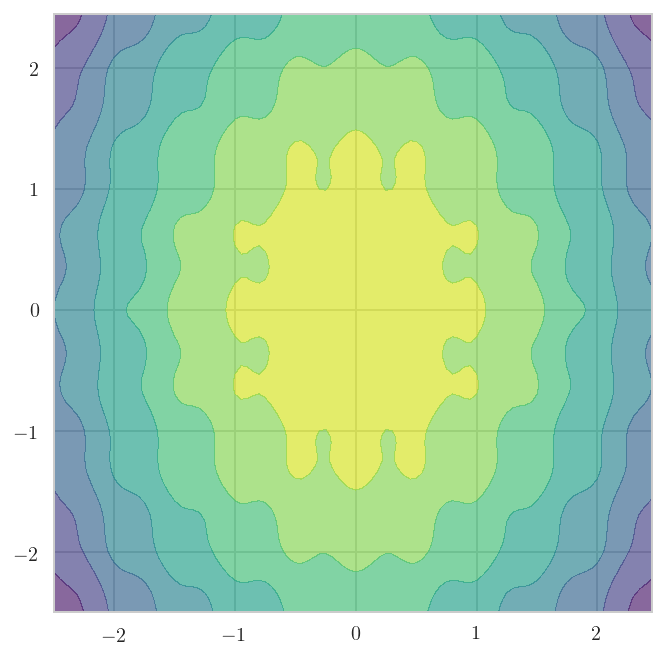

In [26]:
ax = plt.figure().gca()
plot_problem_controur(current_problem, ((-2.5,-2.5), (2.5,2.5)), optimum=(0,0), ax=ax)
ax.set_aspect('equal')

## ($\mu$,$\lambda$) evolutionary strategy

Some basic initialization parameters.

In [27]:
search_space_dims = 2 # we want to plot the individuals so this must be 2

MIN_VALUE, MAX_VALUE = -10., 10.
MIN_STRAT, MAX_STRAT = 0.0000001, 1. 

In [28]:
# We are facing a minimization problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# Evolutionary strategies need a location (mean)
creator.create("Individual", array.array, typecode='d', 
               fitness=creator.FitnessMin, strategy=None)
# ...and a value of the strategy parameter.
creator.create("Strategy", array.array, typecode="d")

Evolutionary strategy individuals are more complex than those we have seen so far.

They need a custom creation/initialization function.

In [29]:
def init_univariate_es_ind(individual_class, strategy_class,
                           size, min_value, max_value, 
                           min_strat, max_strat):
    ind = individual_class(random.uniform(min_value, max_value) 
                           for _ in range(size))
    # we modify the instance to include the strategy in run-time.
    ind.strategy = strategy_class(random.uniform(min_strat, max_strat) for _ in range(size))
    return ind

In [30]:
toolbox = base.Toolbox() 
toolbox.register("individual", init_univariate_es_ind, 
                 creator.Individual, 
                 creator.Strategy,
                 search_space_dims, 
                 MIN_VALUE, MAX_VALUE, 
                 MIN_STRAT, MAX_STRAT)
toolbox.register("population", tools.initRepeat, list, 
                 toolbox.individual)

How does an individual and a population looks like?

In [31]:
ind = toolbox.individual()
pop = toolbox.population(n=3)

In [32]:
def plot_individual(individual, ax=None):
    'Plots an ES indiviual as center and 3*sigma ellipsis.'
    cov = np.eye(len(individual)) * individual.strategy
    plot_cov_ellipse(individual, cov, volume=0.99, alpha=0.56, ax=ax)
    if ax:
        ax.scatter(individual[0], individual[1], 
                    marker='+', color='k', zorder=100)
    else:
        plt.scatter(individual[0], individual[1], 
                    marker='+', color='k', zorder=100)

    
def plot_population(pop, gen=None, max_gen=None, ax=None):
    if gen:
        plt.subplot(max_gen, 1, gen)
        
    for ind in pop:
        plot_individual(ind, ax)

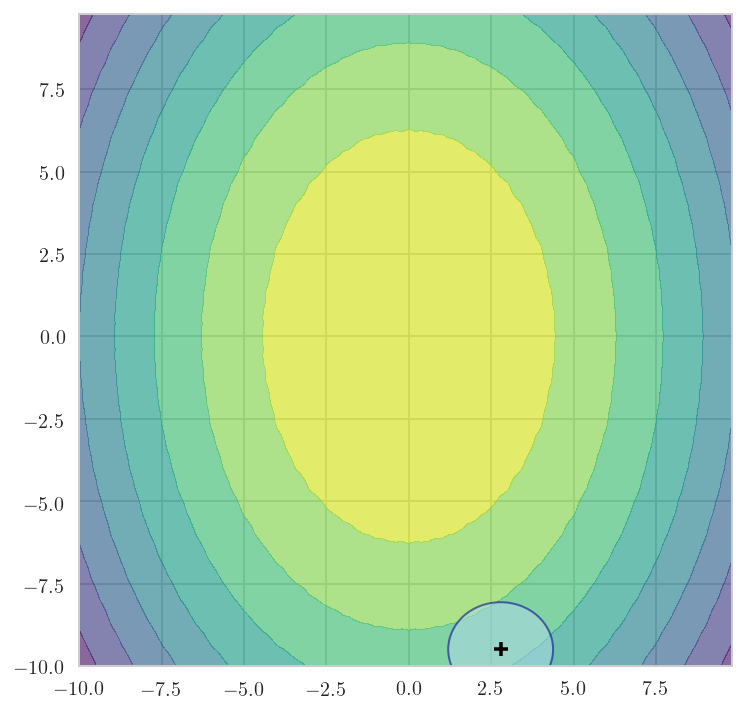

In [33]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), optimum=(0,0))
plot_individual(ind)

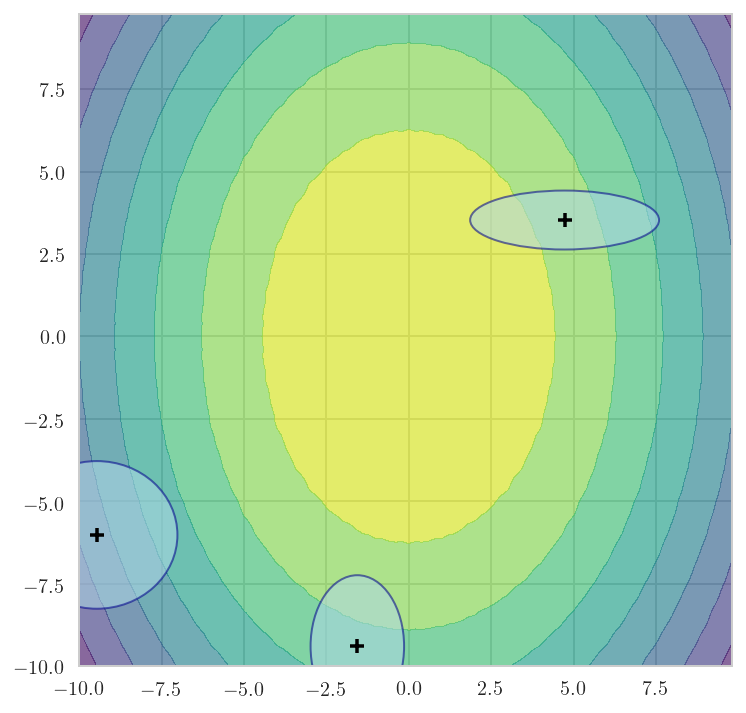

In [34]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), optimum=(0,0))
plot_population(pop)

### Mutation of an evolution strategy individual according to its strategy attribute. 
First the strategy is mutated according to an extended log normal rule, 
$$
\boldsymbol{\sigma}_t = \exp(\tau_0 \mathcal{N}_0(0, 1)) \left[ \sigma_{t-1, 1}\exp(\tau
\mathcal{N}_1(0, 1)), \ldots, \sigma_{t-1, n} \exp(\tau
\mathcal{N}_n(0, 1))\right],
$$
with 
$$\tau_0 =
\frac{c}{\sqrt{2n}}\text{ and }\tau = \frac{c}{\sqrt{2\sqrt{n}}},
$$

the individual is mutated by a normal distribution of mean 0 and standard deviation of $\boldsymbol{\sigma}_{t}$ (its current strategy). 

A recommended choice is $c=1$ when using a $(10,100)$ evolution strategy.

In [35]:
toolbox.register("mutate", tools.mutESLogNormal, c=1, indpb=0.1)

Blend crossover on both, the individual and the strategy.

In [36]:
toolbox.register("mate", tools.cxESBlend, alpha=0.1)
toolbox.register("evaluate", current_problem)
toolbox.register("select", tools.selBest)

In [37]:
mu_es, lambda_es = 3,21

pop = toolbox.population(n=mu_es)
hof = tools.HallOfFame(1)

pop_stats = tools.Statistics(key=copy.deepcopy)
pop_stats.register('pop', copy.deepcopy) # -- copies the populations themselves
    
pop, logbook = algorithms.eaMuCommaLambda(pop, toolbox, mu=mu_es, lambda_=lambda_es, 
        cxpb=0.6, mutpb=0.3, ngen=40, stats=pop_stats, halloffame=hof, verbose=False)

### The final population

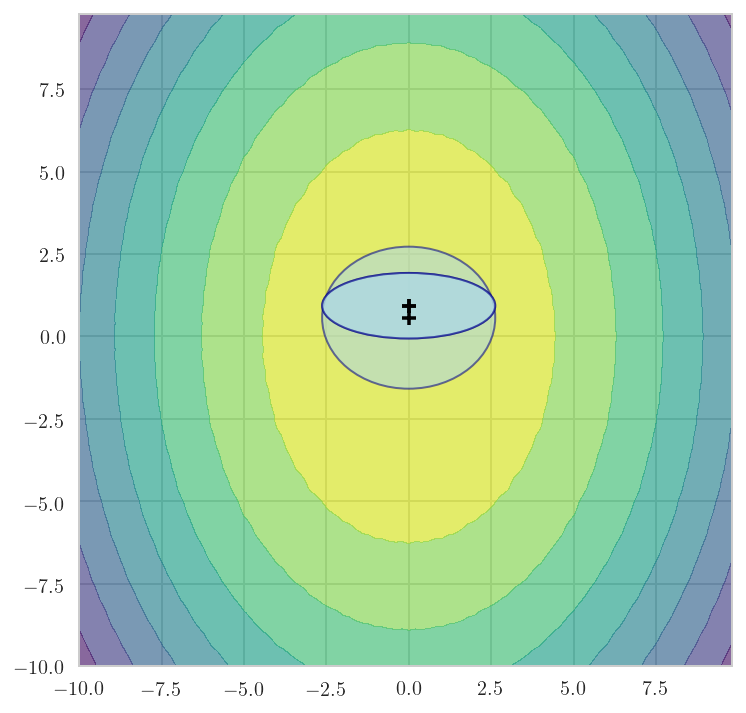

In [38]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), optimum=(0,0))
plot_population(pop)

The plot (most probably) shows a "dark blue" ellipse as all individuals are overlapping. 

Let's see how the evolutionary process took place in animated form.

In [39]:
from matplotlib import animation
from IPython.display import HTML

In [40]:
def animate(i):
    'Updates all plots to match frame _i_ of the animation.'
    ax.clear()
    plot_problem_controur(current_problem, ((-10.1,-10.1), (10.1,10.1)), optimum=(0,0), ax=ax)
    plot_population(logbook[i]['pop'], ax=ax)
    ax.set_title('$t=$' +str(i))
    return []

In [41]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
anim = animation.FuncAnimation(fig, animate, frames=len(logbook), interval=300, blit=True)
plt.close()

In [42]:
HTML(anim.to_html5_video())

How the population progressed as the evolution proceeded?

In [43]:
pop = toolbox.population(n=mu_es)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
    
pop, logbook = algorithms.eaMuCommaLambda(pop, toolbox, 
                                          mu=mu_es, lambda_=lambda_es, 
                                          cxpb=0.6, mutpb=0.3, 
                                          ngen=40, stats=stats, 
                                          verbose=False)

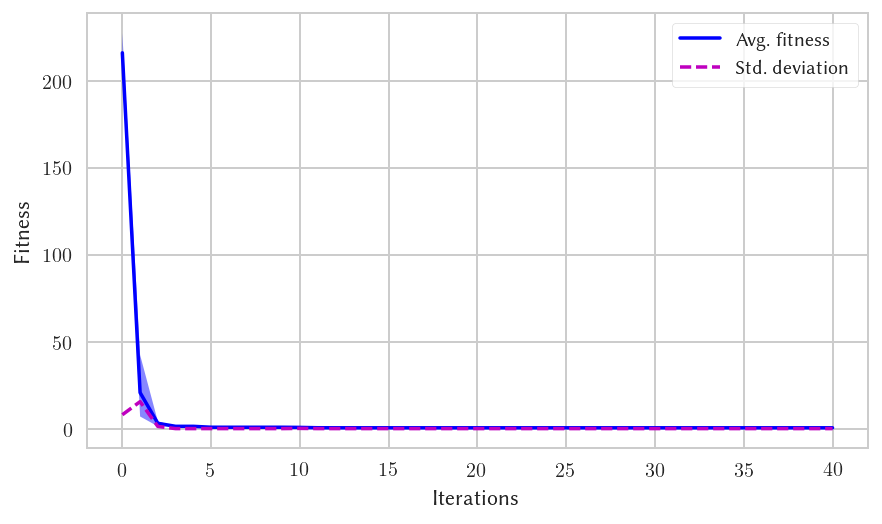

In [44]:
plt.figure(1, figsize=(7, 4))
plt.plot(logbook.select('avg'), 'b-', label='Avg. fitness')
plt.fill_between(range(len(logbook)), logbook.select('max'), logbook.select('min'), facecolor='blue', alpha=0.47)
plt.plot(logbook.select('std'), 'm--', label='Std. deviation')
plt.legend(frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

What happens if we increase $\mu$ and $\lambda$?

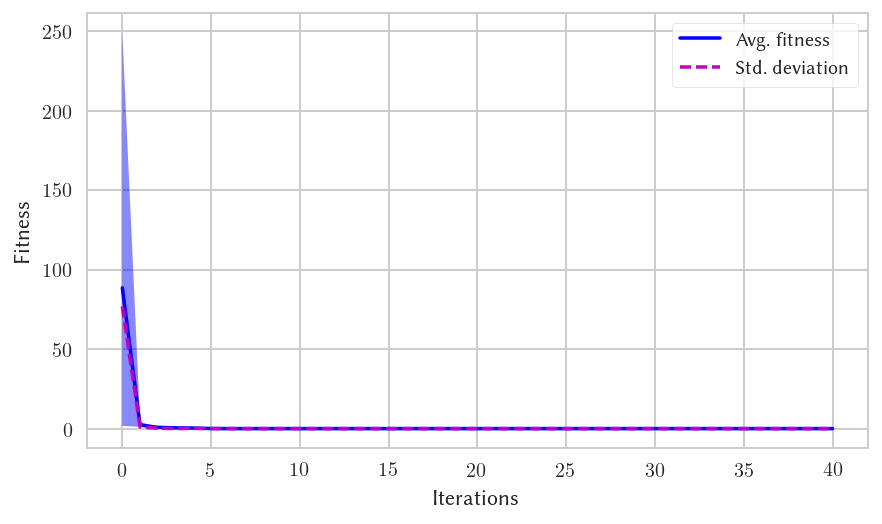

In [45]:
mu_es, lambda_es = 10,100
pop, logbook = algorithms.eaMuCommaLambda(toolbox.population(n=mu_es), toolbox, mu=mu_es, lambda_=lambda_es, 
        cxpb=0.6, mutpb=0.3, ngen=40, stats=stats, halloffame=hof, verbose=False)
plt.figure(1, figsize=(7, 4))
plt.plot(logbook.select('avg'), 'b-', label='Avg. fitness')
plt.fill_between(range(len(logbook)), logbook.select('max'), logbook.select('min'), facecolor='blue', alpha=0.47)
plt.plot(logbook.select('std'), 'm--', label='Std. deviation')
plt.legend(frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

# Covariance Matrix Adaptation Evolutionary Strategy

* In an evolution strategy, new candidate solutions are sampled according to a multivariate normal distribution in the $\mathbb{R}^n$. 
* Recombination amounts to selecting a new mean value for the distribution. 
* Mutation amounts to adding a random vector, a perturbation with zero mean. 
* Pairwise dependencies between the variables in the distribution are represented by a covariance matrix. 

### The covariance matrix adaptation (CMA) is a method to update the covariance matrix of this distribution. 

> This is particularly useful, if the objective function $f()$ is ill-conditioned.

### CMA-ES features

* Adaptation of the covariance matrix amounts to learning a second order model of the underlying objective function.
* This is similar to the approximation of the inverse Hessian matrix in the Quasi-Newton method in classical optimization. 
* In contrast to most classical methods, fewer assumptions on the nature of the underlying objective function are made. 
* *Only the ranking between candidate solutions is exploited* for learning the sample distribution and neither derivatives nor even the function values themselves are required by the method.

In [46]:
from deap import cma

A similar setup to the previous one.

In [47]:
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("evaluate", current_problem)

/Users/lm/anaconda/lib/python3.6/site-packages/deap-1.1.0-py3.6-macosx-10.7-x86_64.egg/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


We will place our start point by hand at $(5,5)$.

In [48]:
cma_es = cma.Strategy(centroid=[5.0]*search_space_dims, sigma=5.0, lambda_=5*search_space_dims)
toolbox.register("generate", cma_es.generate, creator.Individual)
toolbox.register("update", cma_es.update)

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# The CMA-ES algorithm converge with good probability with those settings
pop, logbook = algorithms.eaGenerateUpdate(toolbox, ngen=60, stats=stats, 
                                           halloffame=hof, verbose=False)
    
print("Best individual is %s, fitness: %s" % (hof[0], hof[0].fitness.values))

Best individual is [-4.13583834502141e-07, -1.0707551743796275e-07], fitness: (2.8350655156827997e-12,)


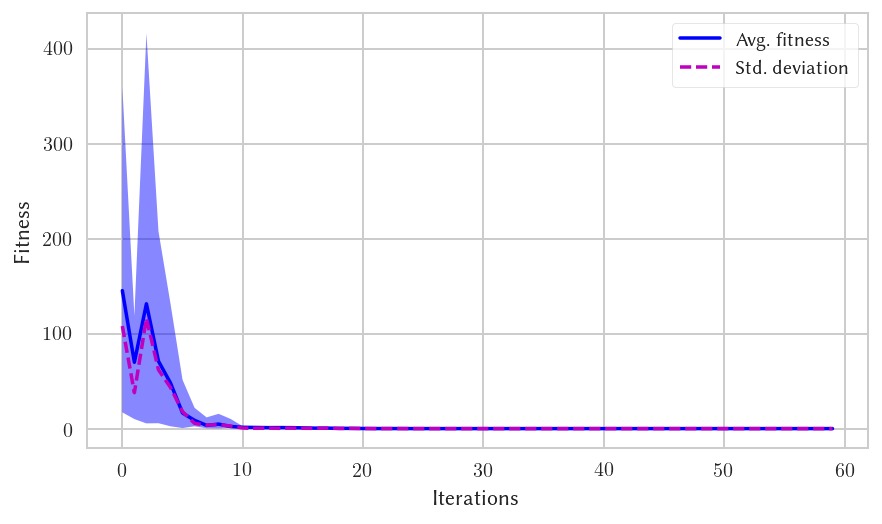

In [49]:
plt.figure(1, figsize=(7, 4))
plt.plot(logbook.select('avg'), 'b-', label='Avg. fitness')
plt.fill_between(range(len(logbook)), logbook.select('max'), logbook.select('min'), facecolor='blue', alpha=0.47)
plt.plot(logbook.select('std'), 'm--', label='Std. deviation')
plt.legend(frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

### OK, but wouldn't it be nice to have an animated plot of how CMA-ES progressed? 

* We need to do some coding to make this animation work.
* We are going to create a class named `PlotableStrategy` that inherits from `deap.cma.Strategy`. This class logs the features we need to make the plots as evolution takes place. That is, for every iteration we store:
    * Current centroid and covariance ellipsoid.
    * Updated centroid and covariance.
    * Sampled individuals.
    * Evolution path.
    
_Note_: I think that DEAP's implementation of CMA-ES has the drawback of storing information that should be stored as part of "individuals". I leave this for an afternoon hack.

In [50]:
from math import sqrt, log, exp
class PlotableStrategy(cma.Strategy):
    """This is a modification of deap.cma.Strategy class.
    We store the execution data in order to plot it.
    **Note:** This class should not be used for other uses than
    the one it is meant for."""
    
    def __init__(self, centroid, sigma, **kargs):
        """Does the original initialization and then reserves 
        the space for the statistics."""
        super(PlotableStrategy, self).__init__(centroid, sigma, **kargs)
        
        self.stats_centroids = []
        self.stats_new_centroids = []
        self.stats_covs = []
        self.stats_new_covs = []
        self.stats_offspring = []
        self.stats_offspring_weights = []
        self.stats_ps = []
    
    def update(self, population):
        """Update the current covariance matrix strategy from the
        *population*.
        
        :param population: A list of individuals from which to update the
                           parameters.
        """
        # -- store current state of the algorithm
        self.stats_centroids.append(copy.deepcopy(self.centroid))
        self.stats_covs.append(copy.deepcopy(self.C))
        
        
        population.sort(key=lambda ind: ind.fitness, reverse=True)
        
        # -- store sorted offspring
        self.stats_offspring.append(copy.deepcopy(population))
        
        old_centroid = self.centroid
        self.centroid = np.dot(self.weights, population[0:self.mu])
        
        # -- store new centroid
        self.stats_new_centroids.append(copy.deepcopy(self.centroid))
        
        c_diff = self.centroid - old_centroid
        
        
        # Cumulation : update evolution path
        self.ps = (1 - self.cs) * self.ps \
             + sqrt(self.cs * (2 - self.cs) * self.mueff) / self.sigma \
             * np.dot(self.B, (1. / self.diagD) \
                          * np.dot(self.B.T, c_diff))
        
        # -- store new evol path
        self.stats_ps.append(copy.deepcopy(self.ps))
        
        hsig = float((np.linalg.norm(self.ps) / 
                sqrt(1. - (1. - self.cs)**(2. * (self.update_count + 1.))) / self.chiN
                < (1.4 + 2. / (self.dim + 1.))))
        
        self.update_count += 1
        
        self.pc = (1 - self.cc) * self.pc + hsig \
                  * sqrt(self.cc * (2 - self.cc) * self.mueff) / self.sigma \
                  * c_diff
        
        # Update covariance matrix
        artmp = population[0:self.mu] - old_centroid
        self.C = (1 - self.ccov1 - self.ccovmu + (1 - hsig) \
                   * self.ccov1 * self.cc * (2 - self.cc)) * self.C \
                + self.ccov1 * np.outer(self.pc, self.pc) \
                + self.ccovmu * np.dot((self.weights * artmp.T), artmp) \
                / self.sigma**2
        
        # -- store new covs
        self.stats_new_covs.append(copy.deepcopy(self.C))
        
        self.sigma *= np.exp((np.linalg.norm(self.ps) / self.chiN - 1.) \
                                * self.cs / self.damps)
        
        self.diagD, self.B = np.linalg.eigh(self.C)
        indx = np.argsort(self.diagD)
        
        self.cond = self.diagD[indx[-1]]/self.diagD[indx[0]]
        
        self.diagD = self.diagD[indx]**0.5
        self.B = self.B[:, indx]
        self.BD = self.B * self.diagD

It is now possible to use/test our new class.

In [51]:
toolbox = base.Toolbox()
toolbox.register("evaluate", current_problem)

In [52]:
max_gens = 40
cma_es = PlotableStrategy(centroid=[5.0]*search_space_dims, sigma=1.0, lambda_=5*search_space_dims)
toolbox.register("generate", cma_es.generate, creator.Individual)
toolbox.register("update", cma_es.update)

# The CMA-ES algorithm converge with good probability with those settings
a = algorithms.eaGenerateUpdate(toolbox, ngen=max_gens, verbose=False)

Me can now code the `animate_cma_es()` function.

In [53]:
norm=colors.Normalize(vmin=np.min(cma_es.weights), vmax=np.max(cma_es.weights))
sm = cm.ScalarMappable(norm=norm, cmap=plt.get_cmap('gray'))

In [54]:
def animate_cma_es(gen):
    ax.cla()
    plot_problem_controur(current_problem, ((-11,-11), (11,11)), optimum=(0,0), ax=ax)
    
    plot_cov_ellipse(cma_es.stats_centroids[gen], cma_es.stats_covs[gen], volume=0.99, alpha=0.29, ax=ax)
    ax.plot(cma_es.stats_centroids[gen][0], cma_es.stats_centroids[gen][1], 'ro', markeredgecolor = 'none', ms=10)
    
    plot_cov_ellipse(cma_es.stats_new_centroids[gen], cma_es.stats_new_covs[gen], volume=0.99, 
                     alpha=0.29, fc='green', ec='darkgreen', ax=ax)
    ax.plot(cma_es.stats_new_centroids[gen][0], cma_es.stats_new_centroids[gen][1], 'go', markeredgecolor = 'none', ms=10)
    
    for i in range(gen+1):
        if i == 0:
            ax.plot((0,cma_es.stats_ps[i][0]),
                     (0,cma_es.stats_ps[i][1]), 'b--')
        else:
            ax.plot((cma_es.stats_ps[i-1][0],cma_es.stats_ps[i][0]),
                     (cma_es.stats_ps[i-1][1],cma_es.stats_ps[i][1]),'b--')
            
    for i,ind in enumerate(cma_es.stats_offspring[gen]):
        if i < len(cma_es.weights):
            color = sm.to_rgba(cma_es.weights[i])
        else:
            color= sm.to_rgba(norm.vmin)
        ax.plot(ind[0], ind[1], 'o', color = color, ms=5, markeredgecolor = 'none')
    
    ax.set_ylim((-10,10))
    ax.set_xlim((-10,10))
    ax.set_title('$t=$' +str(gen))
    return []

### CMA-ES progress 

In [55]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca()
anim = animation.FuncAnimation(fig, animate_cma_es, frames=max_gens, interval=300, blit=True)
plt.close()

In [56]:
HTML(anim.to_html5_video())

* Current centroid and covariance: **red**.
* Updated centroid and covariance: **green**. 
* Sampled individuals: **shades of gray representing their corresponding weight**.
* Evolution path: **blue line starting in (0,0)**. 

## Homework

1. Make an animated plot with the covariance update process. You can rely on the notebook of the previous demonstration class.
2. Compare ES, CMA-ES and a genetic algortihm.
2. How do you think that evolutionary strategies and CMA-ES should be modified in order to cope with combinatorial problems?
3. How can evolution strategies be improved?


<hr/>
<div class="container-fluid">
  <div class='well'>
      <div class="row">
          <div class="col-md-3" align='center'>
              <img align='center'alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png"/>
          </div>
          <div class="col-md-9">
              This work is licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-nc-sa/4.0/).
          </div>
      </div>
  </div>
</div>

In [57]:
# To install run: pip install version_information
%load_ext version_information
%version_information scipy, numpy, matplotlib, seaborn, deap

Software versions
Python 3.6.0 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython 5.2.2
OS Darwin 16.4.0 x86_64 i386 64bit
scipy 0.18.1
numpy 1.11.3
matplotlib 2.0.0
seaborn 0.7.1
deap 1.1
Sat Mar 04 02:57:13 2017 BRT

In [58]:
# this code is here for cosmetic reasons
from IPython.core.display import HTML
from urllib.request import urlopen
HTML(urlopen('https://raw.githubusercontent.com/lmarti/jupyter_custom/master/custom.include').read().decode('utf-8'))